In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import re
from datetime import datetime


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class SimpleRNN:
    # h_t = tanh(W_hh @ h_{t-1} + W_xh @ x_t + b_h)
    def __init__(self, input_dim : int, hidden_dim: int):
        self.W_hh = np.random.randn(hidden_dim, hidden_dim)
        self.W_xh = np.random.randn(hidden_dim, input_dim)
        self.b_h = np.zeros((hidden_dim, 1))
        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev):
        return np.tanh(self.W_hh @ h_prev + self.W_xh @ x + self.b_h)

    def forward_sequence(self, xs):
        h = np.zeros((self.hidden_dim,1))
        hs = []
        for t, x in enumerate(xs):
            h = self.forward(x, h)
            hs.append(h)
            print(f" t= {t}: ||h|| = {np.linalg.norm(h):.4f}, min = {h.min():.3f}, max = {h.max():.3f}")
        return hs


In [3]:
rnn = SimpleRNN(input_dim = 10, hidden_dim=20)
sequence = [np.random.randn(10, 1) for _ in range(5)]

In [4]:
hidden_state = rnn.forward_sequence(sequence)

 t= 0: ||h|| = 3.8533, min = -1.000, max = 1.000
 t= 1: ||h|| = 4.1667, min = -1.000, max = 1.000
 t= 2: ||h|| = 4.1353, min = -1.000, max = 1.000
 t= 3: ||h|| = 4.3341, min = -1.000, max = 1.000
 t= 4: ||h|| = 4.0233, min = -1.000, max = 1.000


In [5]:
hidden_state[1].shape

(20, 1)

In [6]:
rnn_viz = SimpleRNN(input_dim=5, hidden_dim=8)
long_seq = [np.random.randn(5, 1) for _ in range(20)]

In [7]:
h = np.zeros((8, 1))
all_h = []
for x in long_seq:
    h = rnn_viz.forward(x, h)
    all_h.append(h.flatten())
all_h = np.array(all_h)

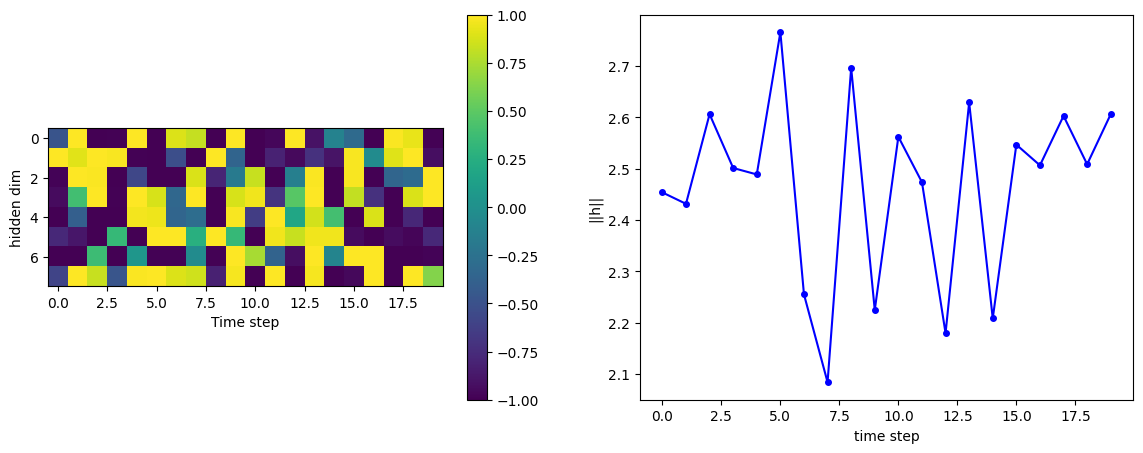

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im = axes[0].imshow(all_h.T, vmin=-1, vmax=1)
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('hidden dim')
plt.colorbar(im, ax=axes[0])

norms = [np.linalg.norm(h) for h in all_h]
axes[1].plot(norms, 'b-o', markersize=4)
axes[1].set_xlabel('time step')
axes[1].set_ylabel('||h||')

plt.show()

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import time, random, warnings

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
DEVICE

device(type='cuda')

In [11]:
class Vocab:
    def __init__(self):
        self.t2i = {"<PAD>" : 0, "<SOS>" : 1, "<EOS>" : 2, "<UNK>" : 3}
        self.i2t = {v:k for k, v in self.t2i.items()}  # {0 : "<PAD>" , 1: "<SOS>"

    def build(self, sentences):
        for s in sentences:
            for t in s:
                if t not in self.t2i:
                    idx = len(self.t2i)
                    self.t2i[t] = idx
                    self.i2t[idx] = t

    def encode(self, tokens):
        return [self.t2i.get(t, 3) for t in tokens]

    def decode(self, ids):
        return [self.i2t.get(i, "?") for i in ids if i not in (0,1,2)]

    def __len__(self):
        return len(self.t2i)

In [12]:
def collate_fn(batch):
    src, tgt = zip(*batch)
    max_src = max(len(x) for x in src)
    max_tgt = max(len(x) for x in tgt)
    src_padded = torch.tensor([list(x) + [0] * (max_src - len(x)) for x in src])
    tgt_padded = torch.tensor([list(x) + [0] * (max_tgt - len(x)) for x in tgt])
    return src_padded.to(DEVICE), tgt_padded.to(DEVICE)

In [13]:
def plot_attention_heatmap(attn_weights, src_tokens, tgt_tokens, title="attention"):
    fig, ax = plt.subplots(figsize = (8, 6))
    sns.heatmap(attn_weights, annot=True, fmt=".2f", cmap="Blues", xticklabels=src_tokens, yticklabels=tgt_tokens, ax=ax)
    ax.set_xlabel("source (encoder)")
    ax.set_ylabel("target (decoder)")
    ax.set_title(title)
    plt.show()


In [14]:
def plot_loss_curves(losses_dict, title = "training loss"):
    fig, ax = plt.subplots(figsize = (10, 5))
    for name, losses in losses_dict.items():
        ax.plot(losses, label = name, linewidth = 2)

    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_title(title)
    plt.show()

In [15]:
RAW_PAIRS = [
    ("i am a student", "ich bin ein student"),
    ("he is a teacher", "er ist ein lehrer"),
    ("she is happy", "sie ist gluecklich"),
    ("we are friends", "wir sind freunde"),
    ("they are here", "sie sind hier"),
    ("i love you", "ich liebe dich"),
    ("the cat is small", "die katze ist klein"),
    ("the dog is big", "der hund ist gross"),
    ("i have a book", "ich habe ein buch"),
    ("you are smart", "du bist klug"),
    ("he runs fast", "er laeuft schnell"),
    ("she sings well", "sie singt gut"),
    ("we eat food", "wir essen essen"),
    ("they play games", "sie spielen spiele"),
    ("i read books", "ich lese buecher"),
    ("the sun is bright", "die sonne ist hell"),
    ("water is cold", "wasser ist kalt"),
    ("i am tired", "ich bin muede"),
    ("he is strong", "er ist stark"),
    ("the house is old", "das haus ist alt"),
    ("she has a cat", "sie hat eine katze"),
    ("we love music", "wir lieben musik"),
    ("i need help", "ich brauche hilfe"),
    ("you are beautiful", "du bist schoen"),
    ("the bird is free", "der vogel ist frei"),
]

In [16]:
data_pairs =  RAW_PAIRS * 20
random.shuffle(data_pairs)

In [17]:
src_sents = [s.split() for s, _ in data_pairs]
tgt_sents = [s.split() for _, s in data_pairs]

In [18]:
tgt_sents[:3]

[['ich', 'brauche', 'hilfe'],
 ['er', 'ist', 'ein', 'lehrer'],
 ['ich', 'bin', 'ein', 'student']]

In [19]:
src_vocab, tgt_vocab = Vocab(), Vocab()
src_vocab.build(src_sents)
tgt_vocab.build(tgt_sents)

In [20]:
{"<PAD>" : 0, "<SOS>" : 1, "<EOS>" : 2, "<UNK>" : 3}
encoded_pairs = [
    (src_vocab.encode(s) + [2], [1] + tgt_vocab.encode(t) + [2]) for s, t in zip(src_sents, tgt_sents)]

In [21]:
# encoded_pairs

In [22]:
train_pairs = encoded_pairs[:400]
test_pairs = encoded_pairs[400:]

In [23]:
train_loader = DataLoader(train_pairs, batch_size = 32, shuffle = True, collate_fn = collate_fn)

In [24]:
len(src_vocab), len(tgt_vocab)

(53, 57)

In [25]:
len(train_pairs), len(test_pairs)

(400, 100)

In [26]:
class SharedEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)   # learnable parameter
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True, bidirectional=True)
        self.fc_h = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_c = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        # src : (batch, src_len)   5 : (5, 77)
        embedded = self.embedding(src) # (batch, src_len, embed_dim)
        outputs, (h_n, c_n) = self.lstm(embedded) # output : (batch, src_len, hidden*2) / h_n : (2, batch, hidden)
        h = torch.tanh(self.fc_h(torch.cat([h_n[0], h_n[1]], dim=-1)))
        c = torch.tanh(self.fc_c(torch.cat([c_n[0], c_n[1]], dim=-1)))

        return outputs, (h.unsqueeze(0), c.unsqueeze(0))

In [27]:
EMBED_DIM = 64
HIDDEN_DIM = 128

In [28]:
test_enc = SharedEncoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
dummy_src = torch.randint(1, 10, (2, 5)).to(DEVICE)
outputs, (h, c) = test_enc(dummy_src)

In [29]:
dummy_src.shape

torch.Size([2, 5])

In [30]:
outputs.shape, h.shape, c.shape

(torch.Size([2, 5, 256]), torch.Size([1, 2, 128]), torch.Size([1, 2, 128]))

In [31]:
# p(y1, . . . , yT′ |x1, . . . , xT )

In [32]:
# P(라면을 먹다 | 비가 온다) : 비오는 날 라면을 먹을 확률
# P(눈이 온다 | 휴가 ) : 휴가일때 눈이 올 확률
# P(휴가 | 눈이 온다 ) : 눈이 올때 휴가갈 확률 90%

# P(A | B) : B가 일어날 때 A가 발생할 확률
# p(y1, . . . , yT′ | x1, . . . , xT ) : i go to school -> I GO TO SCHOOL   maximize  -> MLE (Maximum Likelihood Estimator)

In [33]:
# p(y1 | v, y0) * p(y2 | v, y1) * p(y3 | v, y1, y2) * p(y4 | v, y1, y2, y3) * ,,, * p(y_T' | v, y1, y2, ,,, y_T'-1)

In [34]:
# p(y1 | v, y0) : v, <sos> -> I
# p(y2 | v, y0, y1) : v, <sos>, I -> GO
# v, <sos> I, Go -> TO
# v, <sos> .. TO -> SCHOOL

In [35]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, encoder_outputs=None):
        embedded = self.embedding(x) # (batch, 1, embed_dim)
        output, hidden = self.lstm(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, None

In [36]:
def train_seq2seq(encoder, decoder, train_loader, tgt_vocab_size, n_epochs=100, lr=0.001, print_every=20):
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(params, lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    losses = []

    for epoch in range(n_epochs):
        encoder.train()
        decoder.train()
        epoch_loss = 0

        for src, tgt in train_loader:
            encoder_outputs, hidden = encoder(src)
            batch_size = tgt.size(0)
            tgt_len = tgt.size(1) - 1
            outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(DEVICE)

            decoder_input = tgt[:, 0:1]
            for t in range(tgt_len):
                pred, hidden, _ = decoder(decoder_input, hidden, encoder_outputs)
                outputs[:, t] = pred
                decoder_input = tgt[:, t+1:t+2]

            loss = criterion(outputs.reshape(-1, tgt_vocab_size), tgt[:,1:].reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(params, 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if (epoch + 1) % print_every == 0:
            print(f" Epoch {epoch +1 : 3d} / {n_epochs} : loss = {avg_loss:.4f}")

    return losses

In [37]:
encoder = SharedEncoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
decoder = Decoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)

losses = train_seq2seq(encoder, decoder, train_loader, tgt_vocab_size = len(tgt_vocab), n_epochs=100, lr=0.001, print_every=20)

 Epoch  20 / 100 : loss = 0.0313
 Epoch  40 / 100 : loss = 0.0082
 Epoch  60 / 100 : loss = 0.0039
 Epoch  80 / 100 : loss = 0.0023
 Epoch  100 / 100 : loss = 0.0016


In [38]:
def translate(src_text, encoder, decoder, src_v, tgt_v, max_len=20):
    encoder.eval()
    decoder.eval()

    # {"<PAD>" : 0, "<SOS>" : 1, "<EOS>" : 2, "<UNK>" : 3}
    # tgt_v.i2t[0] -> <PAD>
    tokens = src_text.lower().split()
    src_ids = src_v.encode(tokens) + [2]

    with torch.no_grad():
        src_tensor = torch.tensor([src_ids]).to(DEVICE)
        enc_outputs, hidden = encoder(src_tensor)
        decoder_input = torch.tensor([[1]]).to(DEVICE)
        result = []
        all_attn = []

        for _ in range(max_len):
            pred, hidden, attn_w = decoder(decoder_input, hidden, enc_outputs)
            if attn_w is not None:
                all_attn.append(attn_w.squeeze(0).cpu().numpy())
            top1 = pred.argmax(-1)
            if top1.item() == 2:
                break
            result.append(top1.item())
            decoder_input = top1.unsqueeze(0)

    pred_text = " ".join(tgt_v.decode(result))
    attn_matrix = np.array(all_attn) if all_attn else None

    return pred_text, attn_matrix, tokens

In [39]:
test_sentences = [
    ("i am a student", "ich bin ein student"),
    ("the cat is small", "die katze ist klein"),
    ("i love you", "ich liebe dich"),
    ("he runs fast", "er laeuft schnell"),
    ("she is happy", "sie ist gluecklich"),
    ("you are beautiful", "du bist schoen"),
]

In [40]:
correctness = 0
for en, de in test_sentences:
    pred, _, _ = translate(en, encoder, decoder, src_vocab, tgt_vocab, max_len=20)
    ok = pred.strip() == de
    correctness += ok
    mark = "O" if ok else "X"
    print(f"{mark} EN : {en} |  PRED : {pred} |  REF : {de}")

O EN : i am a student |  PRED : ich bin ein student |  REF : ich bin ein student
O EN : the cat is small |  PRED : die katze ist klein |  REF : die katze ist klein
O EN : i love you |  PRED : ich liebe dich |  REF : ich liebe dich
O EN : he runs fast |  PRED : er laeuft schnell |  REF : er laeuft schnell
O EN : she is happy |  PRED : sie ist gluecklich |  REF : sie ist gluecklich
O EN : you are beautiful |  PRED : du bist schoen |  REF : du bist schoen


In [41]:
hidden_dims = [32, 64, 128, 256]
final_losses = []

for hid in hidden_dims:
    enc_q = SharedEncoder(len(src_vocab), EMBED_DIM, hid).to(DEVICE)
    dec_q = Decoder(len(tgt_vocab), EMBED_DIM, hid).to(DEVICE)
    losses_q = train_seq2seq(enc_q, dec_q, train_loader, len(tgt_vocab), n_epochs=30, print_every=30)
    final_losses.append(losses_q[-1])

 Epoch  30 / 30 : loss = 0.2756
 Epoch  30 / 30 : loss = 0.0579
 Epoch  30 / 30 : loss = 0.0132
 Epoch  30 / 30 : loss = 0.0042


In [42]:
final_losses

[0.2756089510825964,
 0.0578507726582197,
 0.01321668543208104,
 0.004153858440426679]

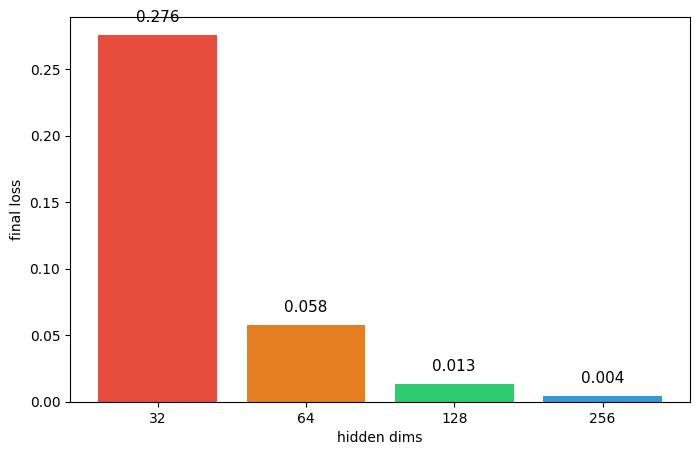

In [43]:
fig, ax = plt.subplots(figsize=(8,5))
colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db']
bars = ax.bar([str(h) for h in hidden_dims], final_losses, color=colors)
ax.set_xlabel('hidden dims')
ax.set_ylabel('final loss')
for bar, loss in zip(bars, final_losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{loss:.3f}', ha='center', fontsize=11)

plt.show()

In [44]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim, enc_output_dim):
        super().__init__()
        self.W_dec = nn.Linear(hidden_dim, hidden_dim)
        self.W_enc = nn.Linear(enc_output_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden : (batch, hidden_dim)
        # encoder_outputs : (batch, src_len, enc_output_dim)
        src_len = encoder_outputs.size(1)

        dec_expanded = self.W_dec(decoder_hidden).unsqueeze(1).repeat(1, src_len, 1)
        enc_transformed = self.W_enc(encoder_outputs)

        energy = self.v(torch.tanh(dec_expanded + enc_transformed))  # (batch, src_len, hidden)
        scores = energy.squeeze(-1) # (batch, src_len)

        attn_weights = F.softmax(scores, dim=-1) # (batch, src_len)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # (batch, enc_outputs_dim)
        
        return context, attn_weights

class BahdanauDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, enc_output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim + enc_output_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim + enc_output_dim, vocab_size)
        self.attention = BahdanauAttention(hidden_dim, enc_output_dim)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x)    # (batch, 1, embed_dim)

        context, attn_weights = self.attention(hidden[0].squeeze(0), encoder_outputs)
        
        lstm_input = torch.cat([embedded, context.unsqueeze(1)], dim=-1)
        output, hidden = self.lstm(lstm_input, hidden)
        
        prediction = self.fc_out(torch.cat([output.squeeze(1), context], dim=-1))

        return prediction, hidden, attn_weights

In [45]:
ENC_OUTPUT_DIM = HIDDEN_DIM * 2

In [46]:
HIDDEN_DIM

128

In [47]:
# class SharedEncoder(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.embedding = nn.Embedding(vocab_size, embed_dim)   # learnable parameter
#         self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True, bidirectional=True)
#         self.fc_h = nn.Linear(hidden_dim * 2, hidden_dim)
#         self.fc_c = nn.Linear(hidden_dim * 2, hidden_dim)

#     def forward(self, src):

# class BahdanauDecoder(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, enc_output_dim):

In [48]:
bahdanau_enc = SharedEncoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
bahdanau_dec = BahdanauDecoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM, ENC_OUTPUT_DIM).to(DEVICE)

In [49]:
total_params = sum([p.numel() for p in bahdanau_enc.parameters()]) + sum([p.numel() for p in bahdanau_dec.parameters()])
total_params

573369

In [50]:
# train_seq2seq(encoder, decoder, train_loader, tgt_vocab_size, n_epochs=100, lr=0.001, print_every=20)
bahdanau_losses = train_seq2seq(bahdanau_enc, bahdanau_dec, train_loader, tgt_vocab_size = len(tgt_vocab), n_epochs =100, print_every=25)

 Epoch  25 / 100 : loss = 0.0042
 Epoch  50 / 100 : loss = 0.0012
 Epoch  75 / 100 : loss = 0.0006
 Epoch  100 / 100 : loss = 0.0004


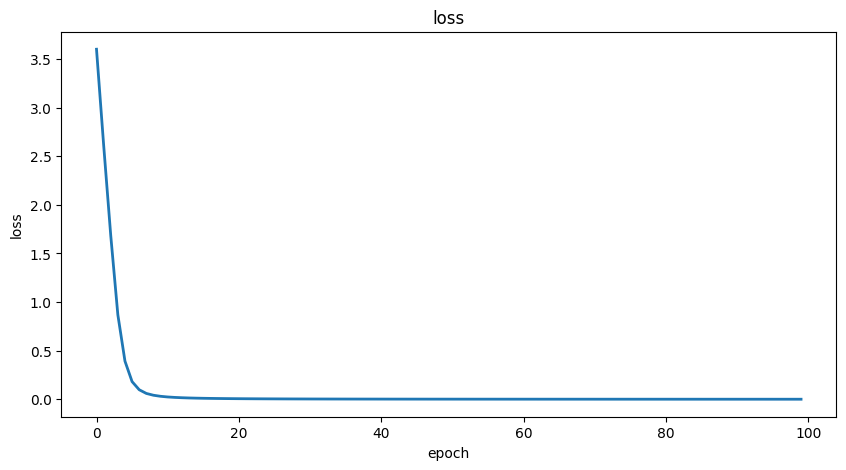

In [51]:
plot_loss_curves(
    {"bahdanau" : bahdanau_losses}, title = "loss")

In [52]:
test_sentences

[('i am a student', 'ich bin ein student'),
 ('the cat is small', 'die katze ist klein'),
 ('i love you', 'ich liebe dich'),
 ('he runs fast', 'er laeuft schnell'),
 ('she is happy', 'sie ist gluecklich'),
 ('you are beautiful', 'du bist schoen')]

 O EN : i am a student |  PRED : ich bin ein student | Ref : ich bin ein student
 O EN : the cat is small |  PRED : die katze ist klein | Ref : die katze ist klein
 O EN : i love you |  PRED : ich liebe dich | Ref : ich liebe dich
 O EN : he runs fast |  PRED : er laeuft schnell | Ref : er laeuft schnell
 O EN : she is happy |  PRED : sie ist gluecklich | Ref : sie ist gluecklich
 O EN : you are beautiful |  PRED : du bist schoen | Ref : du bist schoen


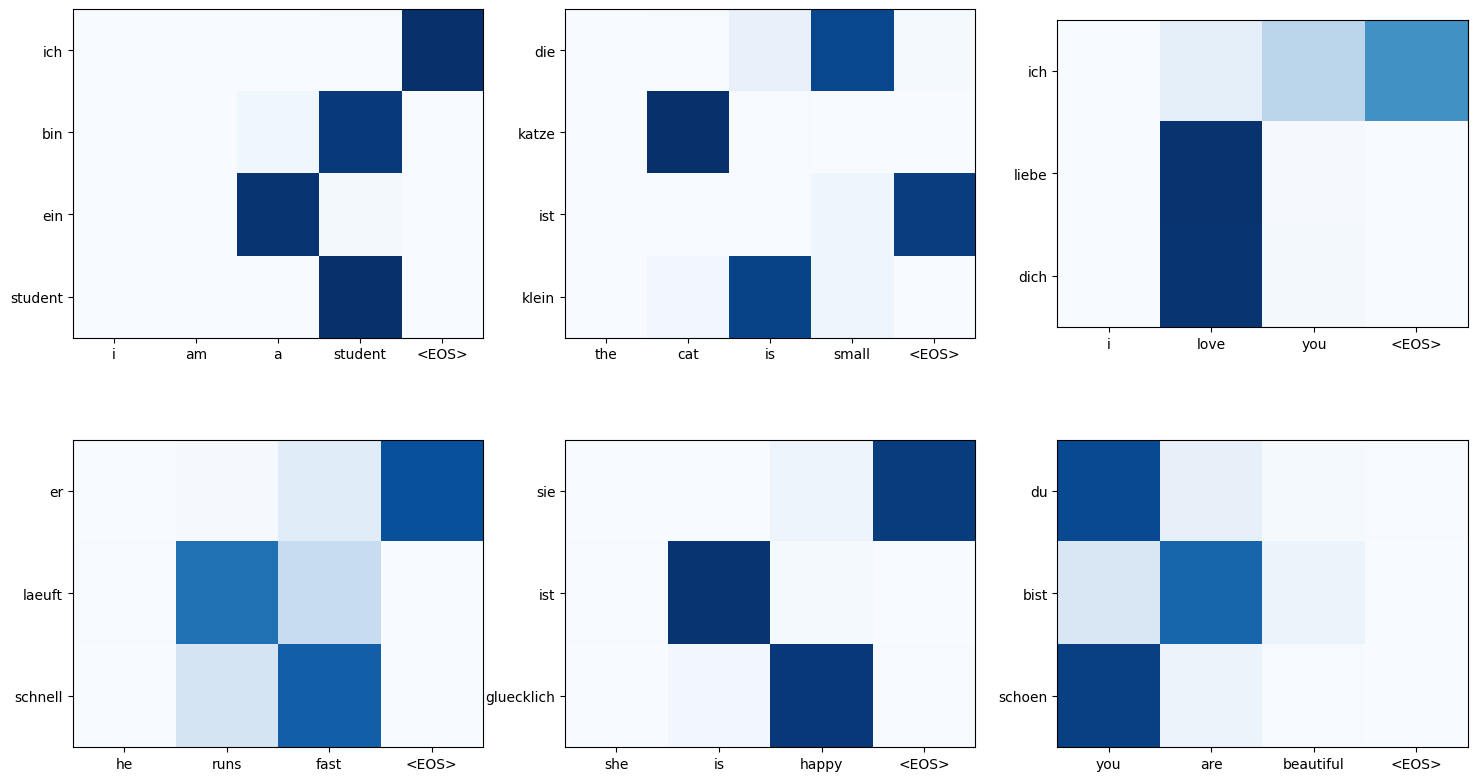

In [53]:
# def translate(src_text, encoder, decoder, src_v, tgt_v, max_len=20)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for idx, (en, de) in enumerate(test_sentences):
    pred, attn, src_tokens = translate(en, bahdanau_enc, bahdanau_dec, src_vocab, tgt_vocab)
    ok = pred.strip() == de
    mark = "O" if ok else "X"
    print(f" {mark} EN : {en} |  PRED : {pred} | Ref : {de}")

    ax = axes[idx // 3][idx %3]
    if attn is not None and attn.shape[0] > 0:
        pred_tokens = pred.split()
        src_labels = src_tokens + ["<EOS>"]
        sl = min(attn.shape[1], len(src_labels))
        ol = min(attn.shape[0], len(pred_tokens))
        im = ax.imshow(attn[:ol, :sl], cmap='Blues', vmin=0, vmax=1)
        ax.set_xticks(range(sl))
        ax.set_xticklabels(src_labels[:sl])
        ax.set_yticks(range(ol))
        ax.set_yticklabels(pred_tokens[:ol])

plt.show()

In [54]:
# March 15, 2025 -> 2025-03-15
# 15/03/25 -> 2025-03-15
# 15 March 2025 -> 2025-03-15

In [55]:
MONTHS = {
    1: ("January", "Jan"), 2: ("February", "Feb"), 3: ("March", "Mar"),
    4: ("April", "Apr"), 5: ("May", "May"), 6: ("June", "Jun"),
    7: ("July", "Jul"), 8: ("August", "Aug"), 9: ("September", "Sep"),
    10: ("October", "Oct"), 11: ("November", "Nov"), 12: ("December", "Dec")
}

In [56]:
def generate_date_pairs(n = 3000):
    pairs = []
    for _ in range(n):
        month = random.randint(1, 12)
        day = random.randint(1, 28)
        year = random.randint(1990, 2025)
        target = f"{year}-{month:02d}-{day:02d}"

        fmt = random.choice(['full', 'abbr', 'slash', 'dot', 'reverse'])
        if fmt == 'full':
            source = f"{MONTHS[month][0] } {day}, {year}" # March 15, 2025
        elif fmt == 'abbr':
            source = f"{MONTHS[month][1]} {day}, {year}" # 15 Mar 2025
        elif fmt == 'slash':
            source = f"{day:02d}/{month:02d}/{year}" # 15/03/2025
        elif fmt == 'dot':
            source = f"{day:02d}.{month:02d}.{year}" # 15.03.2025
        else:
            source = f'{year}/{month:02d}/{day:02d}' # 2025/03/15

        pairs.append((source, target))
    return pairs

date_pairs = generate_date_pairs(3000)

In [57]:
date_src_vocab, date_tgt_vocab = Vocab(), Vocab()

In [58]:
date_src_sents = [list(s) for s, _ in date_pairs]
date_tgt_sents = [list(s) for _, s in date_pairs]

In [59]:
date_src_vocab.build(date_src_sents)
date_tgt_vocab.build(date_tgt_sents)

In [60]:
date_encoded = [
    (date_src_vocab.encode(list(s)) + [2], [1] + date_tgt_vocab.encode(list(t)) + [2]) for s, t in date_pairs
]

In [61]:
date_train, date_test = date_encoded[:2500], date_encoded[:2500]

In [62]:
len(date_train), len(date_encoded)

(2500, 3000)

In [63]:
date_loader = DataLoader(date_train, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [64]:
len(date_pairs)

3000

In [65]:
len(date_src_vocab), len(date_tgt_vocab)

(44, 15)

In [66]:
HIDDEN_DIM, EMBED_DIM

(128, 64)

In [67]:
ENC_OUTPUT_DIM = HIDDEN_DIM * 2

date_bah_enc = SharedEncoder(len(date_src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
date_bah_dec = BahdanauDecoder(
    len(date_tgt_vocab), EMBED_DIM, HIDDEN_DIM, ENC_OUTPUT_DIM
).to(DEVICE)

total_params = sum(p.numel() for p in date_bah_enc.parameters()) + \
    sum(p.numel() for p in date_bah_dec.parameters())

print(f'총 파라미터: {total_params:,}')

start_time = time.time()
date_bahdanau_losses = train_seq2seq(
    date_bah_enc, date_bah_dec, date_loader,
    tgt_vocab_size=len(date_tgt_vocab), n_epochs=100, print_every=25
)
bahdanau_time = time.time() - start_time
print(f'\n학습시간: {bahdanau_time:.1f}초')

총 파라미터: 553,935
 Epoch  25 / 100 : loss = 0.0007
 Epoch  50 / 100 : loss = 0.0002
 Epoch  75 / 100 : loss = 0.0001
 Epoch  100 / 100 : loss = 0.0000

학습시간: 143.8초


In [68]:
def translate(src_text, encoder, decoder, src_v, tgt_v, max_len=20):
    """번역 + attention 가중치 반환"""
    encoder.eval(); decoder.eval()
    tokens = src_text.lower().split()
    src_ids = src_v.encode(tokens) + [2]  # + <EOS>

    with torch.no_grad():
        src_tensor = torch.tensor([src_ids]).to(DEVICE)
        enc_outputs, hidden = encoder(src_tensor)
        decoder_input = torch.tensor([[1]]).to(DEVICE)  # <SOS>
        result = []
        all_attn = []

        for _ in range(max_len):
            pred, hidden, attn_w = decoder(decoder_input, hidden, enc_outputs)
            if attn_w is not None:
                all_attn.append(attn_w.squeeze(0).cpu().numpy())
            top1 = pred.argmax(-1)
            if top1.item() == 2:  # <EOS>
                break
            result.append(top1.item())
            decoder_input = top1.unsqueeze(0)

    pred_text = " ".join(tgt_v.decode(result))
    attn_matrix = np.array(all_attn) if all_attn else None
    return pred_text, attn_matrix, tokens

In [69]:
def translate_date(src_text, encoder, decoder, src_v, tgt_v, max_len=20, return_debug=False):
    encoder.eval()
    decoder.eval()

    PAD_ID, SOS_ID, EOS_ID, UNK_ID = 0, 1, 2, 3

    # 학습과 동일하게 "문자 단위" 인코딩
    src_tokens = list(src_text.strip())
    src_ids = [src_v.t2i.get(ch, UNK_ID) for ch in src_tokens] + [EOS_ID]

    pred_ids = []
    all_attn = []

    with torch.no_grad():
        src_tensor = torch.tensor([src_ids], dtype=torch.long, device=DEVICE)  # (1, src_len)
        enc_outputs, hidden = encoder(src_tensor)

        dec_input = torch.tensor([[SOS_ID]], dtype=torch.long, device=DEVICE)  # (1, 1)

        for _ in range(max_len):
            logits, hidden, attn_w = decoder(dec_input, hidden, enc_outputs)

            if attn_w is not None:
                all_attn.append(attn_w.squeeze(0).cpu().numpy())

            next_id = int(logits.argmax(dim=-1).item())

            if next_id == EOS_ID:
                break
            if next_id != PAD_ID:
                pred_ids.append(next_id)

            dec_input = torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)

    pred_text = "".join(tgt_v.decode(pred_ids))
    attn_matrix = np.array(all_attn) if all_attn else None

    if return_debug:
        unk_in_src = [ch for ch in src_tokens if src_v.t2i.get(ch, UNK_ID) == UNK_ID]
        return pred_text, attn_matrix, src_tokens, {"unk_chars": unk_in_src, "src_ids": src_ids, "pred_ids": pred_ids}

    return pred_text, attn_matrix, src_tokens

In [70]:
test_date_pairs = generate_date_pairs(5)
test_date_pairs

[('16.11.2016', '2016-11-16'),
 ('March 3, 2025', '2025-03-03'),
 ('16.08.2010', '2010-08-16'),
 ('2007/02/14', '2007-02-14'),
 ('02.02.2021', '2021-02-02')]

In [71]:
for idx, (src, tgt) in enumerate(test_date_pairs):
    pred_text, attn_matrix, tokens = translate_date(src, date_bah_enc, date_bah_dec, date_src_vocab, date_tgt_vocab, max_len=20)
    ok = pred_text.strip() == tgt
    mark = 'O' if ok else 'X'
    print(f'{mark} Input:{src} | Pred:{pred_text} | Ref:{tgt}')

O Input:16.11.2016 | Pred:2016-11-16 | Ref:2016-11-16
O Input:March 3, 2025 | Pred:2025-03-03 | Ref:2025-03-03
O Input:16.08.2010 | Pred:2010-08-16 | Ref:2010-08-16
O Input:2007/02/14 | Pred:2007-02-14 | Ref:2007-02-14
O Input:02.02.2021 | Pred:2021-02-02 | Ref:2021-02-02


In [72]:
def plot_attn_matrix(attn_matrix, src_text, pred_text, title="Attention Heatmap"):
    """
    attn_matrix: (tgt_len, src_len) numpy array
    src_text: 원문 문자열
    pred_text: 예측 문자열
    """
    if attn_matrix is None or len(attn_matrix) == 0:
        print("attn_matrix가 비어 있습니다.")
        return

    src_tokens = list(src_text) + ["<EOS>"]   # 학습 시 src 끝에 EOS 추가했으므로 표시
    tgt_tokens = list(pred_text)              # 날짜 task는 문자 단위 출력

    # 길이 맞춤
    sl = min(attn_matrix.shape[1], len(src_tokens))
    tl = min(attn_matrix.shape[0], len(tgt_tokens))
    A = attn_matrix[:tl, :sl]

    plt.figure(figsize=(max(8, sl * 0.6), max(4, tl * 0.5)))
    plt.imshow(A, cmap="Blues", aspect="auto", vmin=0, vmax=1)
    plt.colorbar(label="attention weight")

    plt.xticks(range(sl), src_tokens[:sl], rotation=45, ha="right")
    plt.yticks(range(tl), tgt_tokens[:tl])

    plt.xlabel("Source")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()


PRED: 2014-11-20


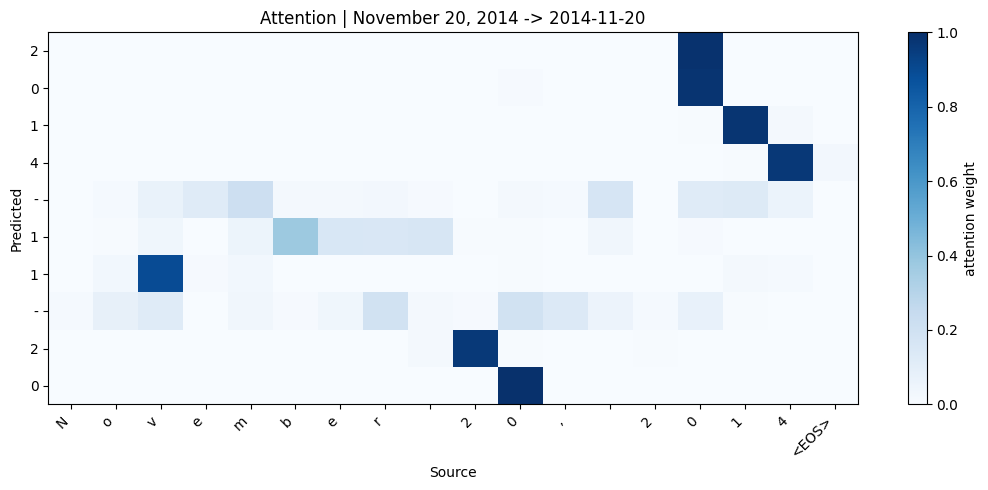

In [73]:
src = "November 20, 2014"
pred, attn_matrix, _ = translate_date(src, date_bah_enc, date_bah_dec, date_src_vocab, date_tgt_vocab, max_len=20)

print("PRED:", pred)
plot_attn_matrix(attn_matrix, src, pred, title=f"Attention | {src} -> {pred}")

In [74]:
# attn_matrix 시각화

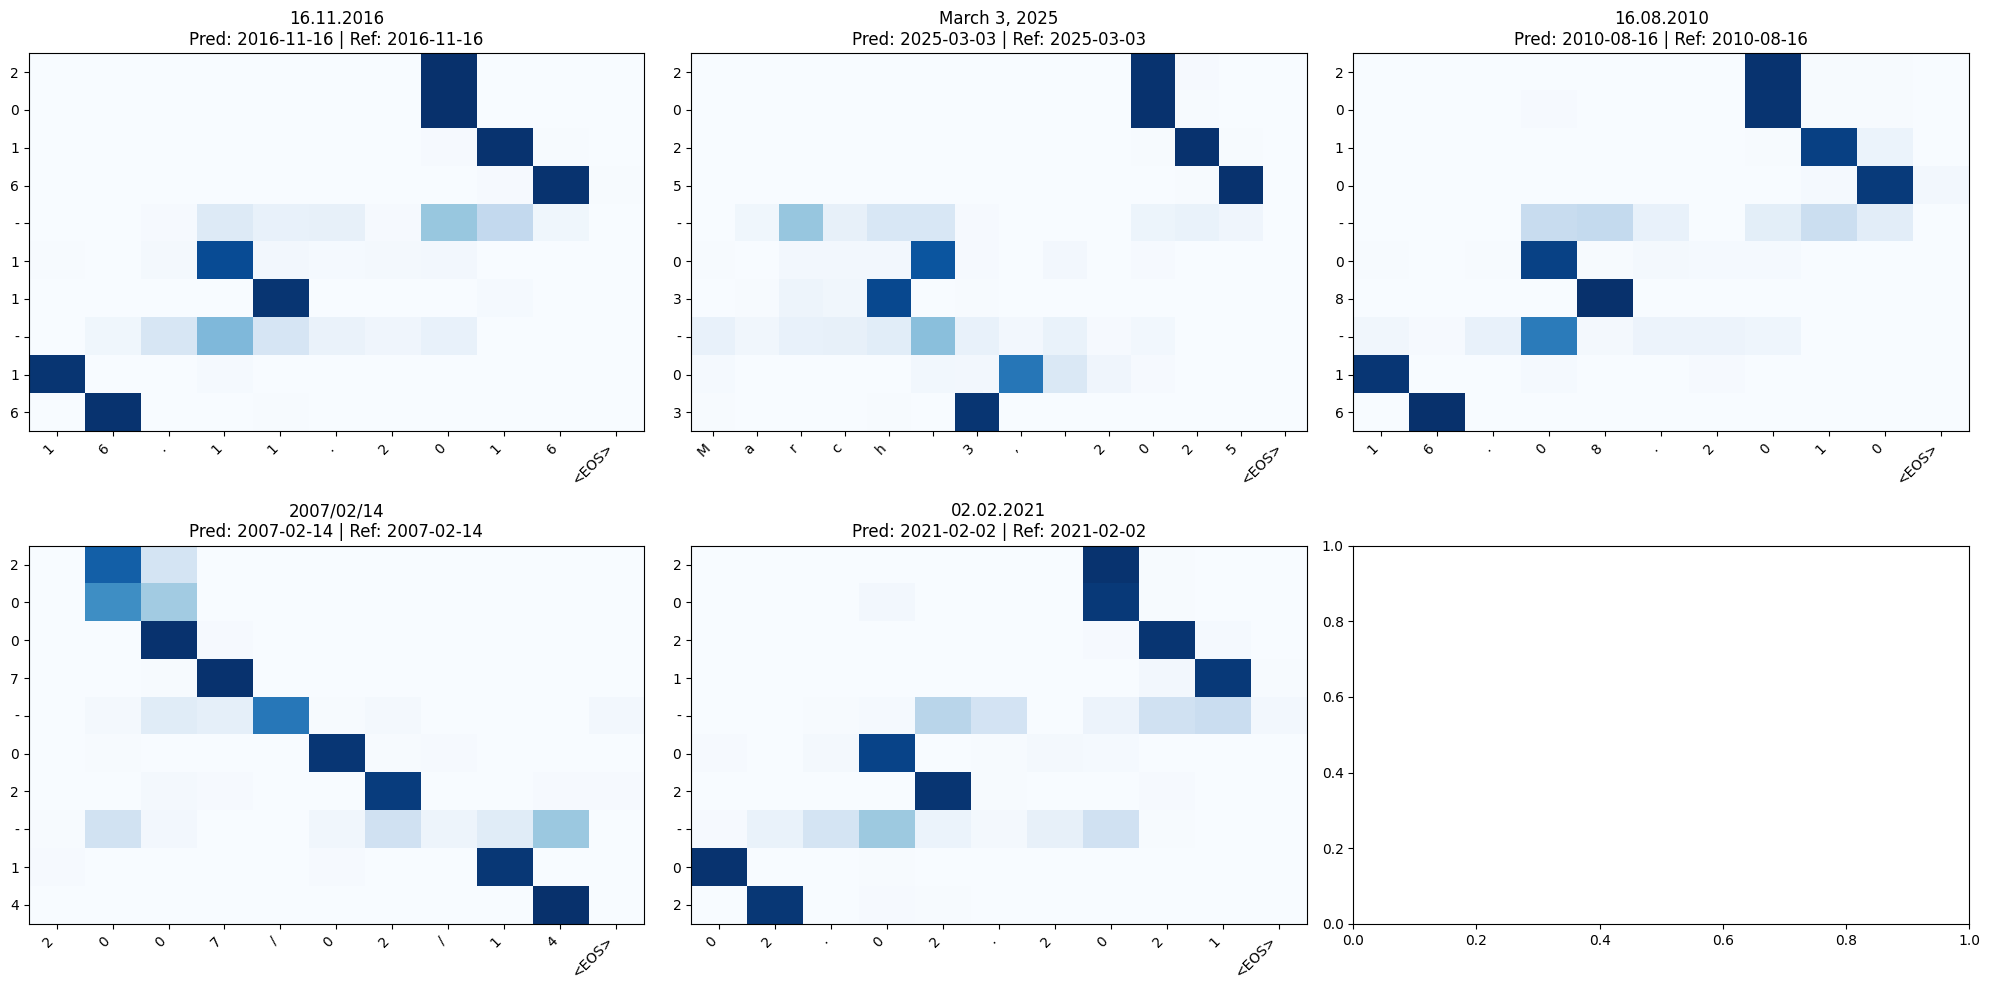

In [75]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for idx, (src, tgt) in enumerate(test_date_pairs[:6]):
    pred_text, attn_matrix, tokens = translate_date(
        src, date_bah_enc, date_bah_dec, date_src_vocab, date_tgt_vocab, max_len=20
    )

    ax = axes[idx // 3][idx % 3]
    if attn_matrix is not None and attn_matrix.shape[0] > 0:
        pred_chars = list(pred_text)
        src_labels = tokens + ["<EOS>"]

        sl = min(attn_matrix.shape[1], len(src_labels))
        ol = min(attn_matrix.shape[0], len(pred_chars))

        A = attn_matrix[:ol, :sl]
        ax.imshow(A, cmap="Blues", vmin=0, vmax=1, aspect="auto")

        ax.set_xticks(range(sl))
        ax.set_xticklabels(src_labels[:sl], rotation=45, ha="right")
        ax.set_yticks(range(ol))
        ax.set_yticklabels(pred_chars[:ol])

    ax.set_title(f"{src}\nPred: {pred_text} | Ref: {tgt}")

plt.tight_layout()
plt.show()

In [76]:
attn_matrix.shape

(11, 11)

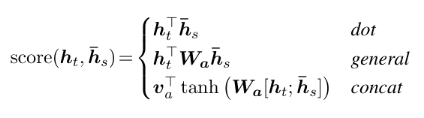

In [ ]:
class LuongAttention(nn.Module):
    """Attention (Luong et al., 2015)"""
    def __init__(self, hidden_dim, enc_output_dim, method = 'dot'):
        super().__init__()
        # enc_output_dim = hidden_dim * 2 (bidirectional)
        self.method = method
        self.hidden_dim = hidden_dim

        if method == 'general':
            self.W = nn.Linear(enc_output_dim, hidden_dim, bias=False)
        elif method == 'concat':
            self.W = nn.Linear(hidden_dim + enc_output_dim, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)
        elif method == 'dot':
            self.proj = nn.Linear(enc_output_dim, hidden_dim, bias=False)

    def forward(self, decoder_output, encoder_outputs):
        # decoder_output: (batch, hidden_dim)
        # encoder_outputs: (batch, src_len, enc_output_dim)

        if self.method == 'general':
            enc_transformed = self.W(encoder_outputs)
            scores = torch.bmm(enc_transformed, decoder_output.unsqueeze(-1)).squeeze(-1)

        elif self.method == 'concat':
            src_len = encoder_outputs.size(1)
            dec_expanded = decoder_output.unsqueeze(1).repeat(1, src_len, 1)   # (batch, hidden_dim) -> (batch, src_len, hidden_dim)
            combined = torch.cat([dec_expanded, encoder_outputs], dim=-1)
            scores = self.v(torch.tanh(self.W(combined))).squeeze(-1)

        elif self.method == 'dot':
            # print(encoder_outputs.shape, decoder_output.shape)
            # scores = torch.bmm(encoder_outputs, decoder_output.unsqueeze(-1)).squeeze(-1)
            enc_proj = self.proj(encoder_outputs)
            scores = torch.bmm(enc_proj, decoder_output.unsqueeze(-1)).squeeze(-1)

        attn_weights = F.softmax(scores, dim=-1)  # (batch, src_len)

        # Context vector
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # (batch, enc_output_dim)

        return context, attn_weights


class LuongDecoder(nn.Module):
    """Luong Attention이 적용된 Decoder"""
    def __init__(self, vocab_size, embed_dim, hidden_dim, enc_output_dim, method = 'dot'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = LuongAttention(hidden_dim, enc_output_dim)  # TODO
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim + enc_output_dim, vocab_size)

    def forward(self, x, hidden, encoder_outputs):
        # x: (batch, 1)
        embedded = self.embedding(x)  # (batch, 1, embed_dim)

        # First, we simply use hidden states at the top LSTM layers in both the
        # encoder and decoder as illustrated in Figure 2.

        output, hidden = self.lstm(embedded, hidden)

        # Attention
        context, attn_weights = self.attention(
            output.squeeze(1), encoder_outputs
        )

        prediction = self.fc_out(
            torch.cat([output.squeeze(1), context], dim=-1)
        )

        return prediction, hidden, attn_weights

In [78]:
test_sentences = [
    ("i am a student", "ich bin ein student"),
    ("the cat is small", "die katze ist klein"),
    ("i love you", "ich liebe dich"),
    ("he runs fast", "er laeuft schnell"),
    ("she is happy", "sie ist gluecklich"),
    ("you are beautiful", "du bist schoen"),
]

In [79]:
luong_results = {}
for method in ['dot', 'general', 'concat']:
    enc = SharedEncoder(len(src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
    dec = LuongDecoder(len(tgt_vocab), EMBED_DIM, HIDDEN_DIM, HIDDEN_DIM*2, method=method).to(DEVICE)

    losses = train_seq2seq(enc, dec, train_loader, len(tgt_vocab), n_epochs=100, print_every=25)

    correct = 0
    for en, de in test_sentences:
        pred, _, _ = translate(en, enc, dec, src_vocab, tgt_vocab)
        if pred.strip() == de:
            correct+=1

    luong_results[method] ={
        'encoder' : enc, 'decoder' : dec, 'losses' : losses, 'accuracy' : correct }

    print(f"accuracy : {correct} / {len(test_sentences)}")

 Epoch  25 / 100 : loss = 0.0046
 Epoch  50 / 100 : loss = 0.0014
 Epoch  75 / 100 : loss = 0.0007
 Epoch  100 / 100 : loss = 0.0004
accuracy : 6 / 6
 Epoch  25 / 100 : loss = 0.0045
 Epoch  50 / 100 : loss = 0.0013
 Epoch  75 / 100 : loss = 0.0007
 Epoch  100 / 100 : loss = 0.0004
accuracy : 6 / 6
 Epoch  25 / 100 : loss = 0.0049
 Epoch  50 / 100 : loss = 0.0015
 Epoch  75 / 100 : loss = 0.0007
 Epoch  100 / 100 : loss = 0.0004
accuracy : 5 / 6


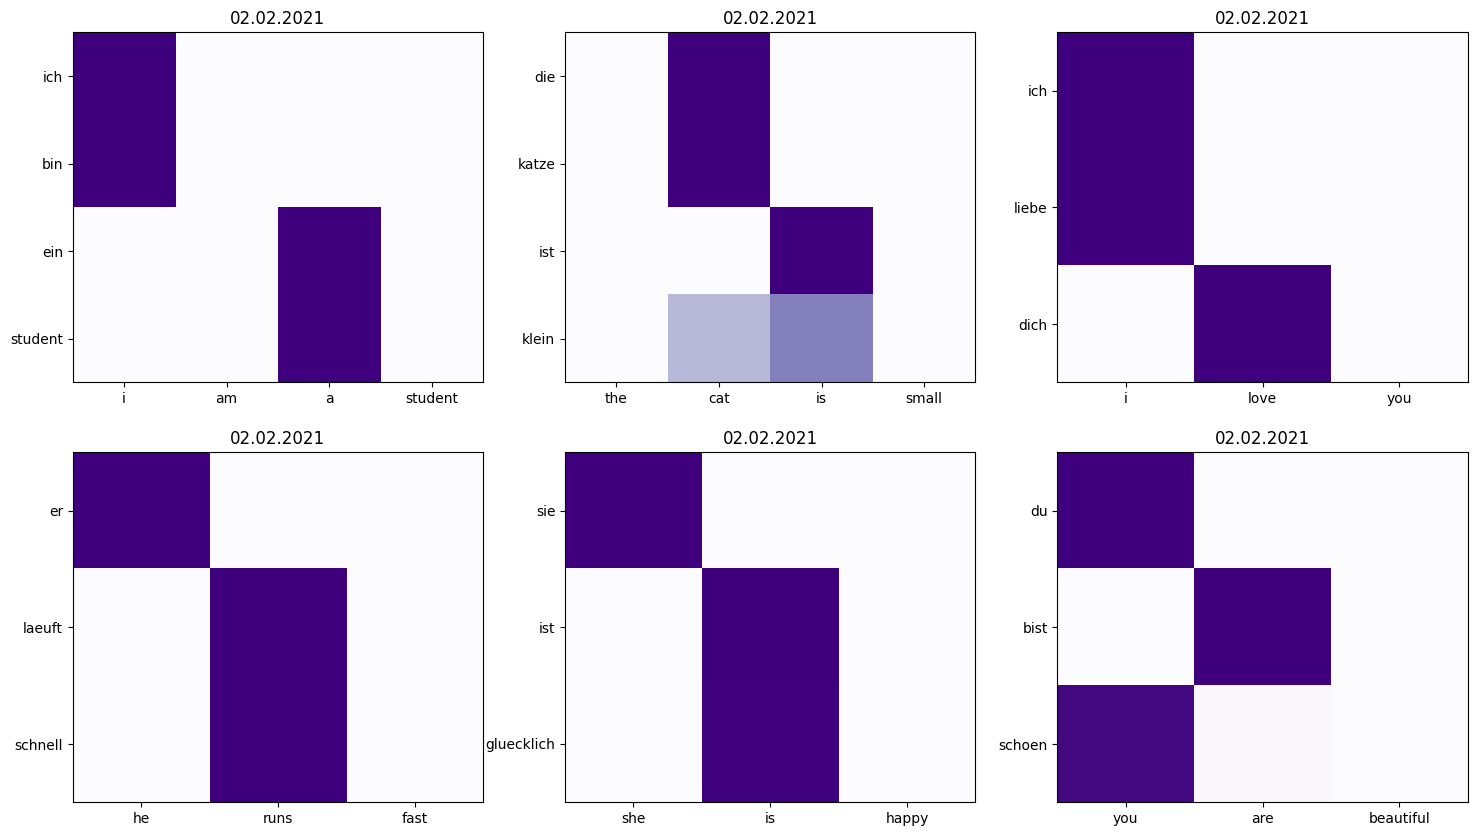

In [81]:
method = 'general'
enc = luong_results[method]['encoder']
dec = luong_results[method]['decoder']

fig, axes = plt.subplots(2, 3, figsize = (18, 10))
for idx, (en, de) in enumerate(test_sentences):
    pred, attn, src_tokens = translate(en, enc, dec, src_vocab, tgt_vocab, max_len=20)

    ax = axes[idx // 3][idx %3]
    if attn is not None and attn.shape[0] > 0:
        pred_tokens = pred.split()
        src_labels = src_tokens
        sl = min(attn.shape[1], len(src_labels))
        ol = min(attn.shape[0], len(pred_tokens))
        ax.imshow(attn[:ol,:sl], cmap='Purples', aspect='auto', vmin=0, vmax=1)
        ax.set_xticks(range(sl))
        ax.set_xticklabels(src_labels[:sl])
        ax.set_yticks(range(ol))
        ax.set_yticklabels(pred_tokens[:ol])
    ax.set_title(f"{src}")

plt.show()

In [82]:
# date_loader
# luong attention 날짜 포맷 변환

In [83]:
date_luong_results = {}
for method in ['dot', 'general', 'concat']:
    enc = SharedEncoder(len(date_src_vocab), EMBED_DIM, HIDDEN_DIM).to(DEVICE)
    dec = LuongDecoder(len(date_tgt_vocab), EMBED_DIM, HIDDEN_DIM, HIDDEN_DIM*2, method=method).to(DEVICE)

    losses = train_seq2seq(enc, dec, date_loader, len(date_tgt_vocab), n_epochs=100, print_every=25)

    correct = 0
    for src, ref in test_date_pairs:
        pred, _, _ = translate_date(src, enc, dec, date_src_vocab, date_tgt_vocab)
        if pred.strip() == ref:
            correct+=1

    date_luong_results[method] ={
        'encoder' : enc, 'decoder' : dec, 'losses' : losses, 'accuracy' : correct }

    print(f"accuracy : {correct} / {len(test_date_pairs)}")

 Epoch  25 / 100 : loss = 0.0132
 Epoch  50 / 100 : loss = 0.0025
 Epoch  75 / 100 : loss = 0.0002
 Epoch  100 / 100 : loss = 0.0002
accuracy : 5 / 5
 Epoch  25 / 100 : loss = 0.0037
 Epoch  50 / 100 : loss = 0.0023
 Epoch  75 / 100 : loss = 0.0006
 Epoch  100 / 100 : loss = 0.0001
accuracy : 5 / 5
 Epoch  25 / 100 : loss = 0.0018
 Epoch  50 / 100 : loss = 0.0006
 Epoch  75 / 100 : loss = 0.0003
 Epoch  100 / 100 : loss = 0.0022
accuracy : 5 / 5


In [84]:
# test_date_pairs

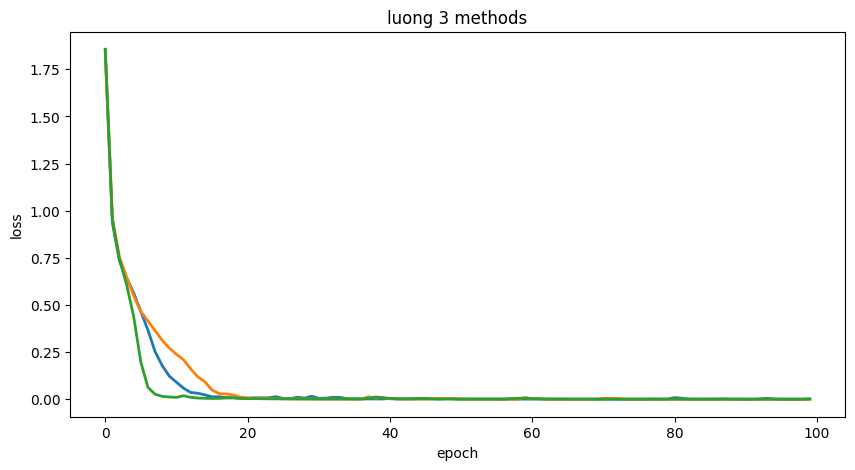

In [85]:
date_loss_dict = {}
for m, r in date_luong_results.items():
    date_loss_dict[f'Luong {m}'] = r['losses']

plot_loss_curves(date_loss_dict, title='luong 3 methods')

In [87]:
def date_format_normalizer(src):
    s = str(src).strip()
    if not s:
        raise ValueError("empty date string")

    # 공백/콤마 정리 (예: "November 20, 2014")
    s = re.sub(r"\s+", " ", s)
    s_no_comma = s.replace(",", "")

    # 시도할 포맷들
    formats = []

    # 1) year-first (예: 1993/04/01, 2012-05-18)
    if re.match(r"^\d{4}[-/\.]\d{1,2}[-/\.]\d{1,2}$", s):
        formats += ["%Y-%m-%d", "%Y/%m/%d", "%Y.%m.%d"]

    # 2) month name (예: November 20, 2014)
    formats += ["%B %d %Y", "%b %d %Y"]

    # 3) day-first numeric (예: 04.02.2000, 05/11/2001)
    formats += ["%d-%m-%Y", "%d/%m/%Y", "%d.%m.%Y"]

    # 4) 필요 시 month-first도 마지막에 시도
    formats += ["%m-%d-%Y", "%m/%d/%Y", "%m.%d.%Y"]

    for fmt in formats:
        try:
            dt = datetime.strptime(s_no_comma, fmt)
            return dt.strftime("%Y-%m-%d")
        except ValueError:
            continue

    raise ValueError(f"지원하지 않는 날짜 형식: {src}")


In [86]:
def _luong_dot_score(dec_h, enc_out):
    # dec_h: (1, H_dec), enc_out: (1, S, H_enc)
    if dec_h.size(-1) != enc_out.size(-1):
        return None
    return torch.bmm(enc_out, dec_h.unsqueeze(2)).squeeze(-1)  # (1, S)

def _luong_general_score(dec_h, enc_out, W_general):
    # W_general: nn.Linear(H_enc -> H_dec, bias=False)
    if W_general is None:
        return None
    proj = W_general(enc_out)  # (1, S, H_dec)
    return torch.bmm(proj, dec_h.unsqueeze(2)).squeeze(-1)  # (1, S)

def _luong_concat_score(dec_h, enc_out, W_concat, v_concat):
    # W_concat: nn.Linear(H_dec + H_enc -> H_dec), v_concat: nn.Linear(H_dec -> 1, bias=False)
    if W_concat is None or v_concat is None:
        return None
    S = enc_out.size(1)
    dec_exp = dec_h.unsqueeze(1).expand(-1, S, -1)  # (1, S, H_dec)
    energy = torch.tanh(W_concat(torch.cat([dec_exp, enc_out], dim=-1)))  # (1, S, H_dec)
    return v_concat(energy).squeeze(-1)  # (1, S)

def visualize_luong_all(
    src_text,
    encoder,
    decoder,
    src_v,
    tgt_v,
    max_len=20,
    char_level=True
):
    """
    decoder.forward(x, hidden, encoder_outputs) -> (pred, hidden, attn)
    를 만족한다고 가정.
    """
    encoder.eval()
    decoder.eval()

    PAD_ID, SOS_ID, EOS_ID, UNK_ID = 0, 1, 2, 3

    # --- source tokenize ---
    src_tokens = list(src_text.strip()) if char_level else src_text.lower().split()
    src_ids = [src_v.t2i.get(t, UNK_ID) for t in src_tokens] + [EOS_ID]

    hidden_steps = []
    pred_ids = []

    with torch.no_grad():
        src_tensor = torch.tensor([src_ids], dtype=torch.long, device=DEVICE)  # (1, S)
        enc_out, hidden = encoder(src_tensor)  # enc_out: (1, S, H_enc)

        dec_input = torch.tensor([[SOS_ID]], dtype=torch.long, device=DEVICE)

        for _ in range(max_len):
            pred, hidden, _ = decoder(dec_input, hidden, enc_out)  # pred: (1, V)
            dec_h = hidden[0].squeeze(0)  # (1, H_dec)
            hidden_steps.append(dec_h)

            next_id = int(pred.argmax(dim=-1).item())
            if next_id == EOS_ID:
                break
            if next_id != PAD_ID:
                pred_ids.append(next_id)

            dec_input = torch.tensor([[next_id]], dtype=torch.long, device=DEVICE)

    # decode prediction
    pred_tokens = tgt_v.decode(pred_ids)
    pred_text = "".join(pred_tokens) if char_level else " ".join(pred_tokens)

    # --- find trained layers from decoder (name fallback) ---
    W_general = (
        getattr(decoder, "W_general", None)
        or getattr(decoder, "attn_general", None)
        or getattr(decoder, "general_linear", None)
    )
    W_concat = (
        getattr(decoder, "W_concat", None)
        or getattr(decoder, "attn_concat", None)
        or getattr(decoder, "concat_linear", None)
    )
    v_concat = (
        getattr(decoder, "v_concat", None)
        or getattr(decoder, "v", None)
        or getattr(decoder, "concat_v", None)
    )

    # --- build attention matrices ---
    mats = {}

    dot_rows = []
    for h in hidden_steps:
        s = _luong_dot_score(h, enc_out)
        if s is None:
            dot_rows = None
            break
        dot_rows.append(F.softmax(s, dim=-1).squeeze(0).cpu().numpy())
    if dot_rows is not None and len(dot_rows) > 0:
        mats["dot"] = np.stack(dot_rows, axis=0)

    gen_rows = []
    for h in hidden_steps:
        s = _luong_general_score(h, enc_out, W_general)
        if s is None:
            gen_rows = None
            break
        gen_rows.append(F.softmax(s, dim=-1).squeeze(0).cpu().numpy())
    if gen_rows is not None and len(gen_rows) > 0:
        mats["general"] = np.stack(gen_rows, axis=0)

    con_rows = []
    for h in hidden_steps:
        s = _luong_concat_score(h, enc_out, W_concat, v_concat)
        if s is None:
            con_rows = None
            break
        con_rows.append(F.softmax(s, dim=-1).squeeze(0).cpu().numpy())
    if con_rows is not None and len(con_rows) > 0:
        mats["concat"] = np.stack(con_rows, axis=0)

    if len(mats) == 0:
        print("시각화할 수 있는 attention이 없습니다. (dot 차원 불일치 또는 general/concat 레이어 미정의)")
        return pred_text, {}

    # --- plot ---
    src_labels = src_tokens + ["<EOS>"]
    tgt_labels = pred_tokens if len(pred_tokens) > 0 else ["<EMPTY>"]

    n = len(mats)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, (name, A) in zip(axes, mats.items()):
        sl = min(A.shape[1], len(src_labels))
        tl = min(A.shape[0], len(tgt_labels))
        M = A[:tl, :sl]

        im = ax.imshow(M, cmap="Blues", vmin=0, vmax=1, aspect="auto")
        ax.set_title(f"Luong-{name}")
        ax.set_xticks(range(sl))
        ax.set_xticklabels(src_labels[:sl], rotation=45, ha="right")
        ax.set_yticks(range(tl))
        ax.set_yticklabels(tgt_labels[:tl])
        ax.set_xlabel("Source")
        ax.set_ylabel("Predicted")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle(f"Input: {src_text}\nPred: {pred_text}", y=1.02)
    plt.tight_layout()
    plt.show()

    return pred_text, mats


In [96]:
print(date_format_normalizer("November 20, 2014"))  # 2014-11-20
print(date_format_normalizer("04.02.2000"))         # 2000-02-04
print(date_format_normalizer("1993/04/01"))         # 1993-04-01
print(date_format_normalizer("05/11/2001"))         # 2001-11-05

2014-11-20
2000-02-04
1993-04-01
2001-11-05


In [90]:
test_date_pairs

[('16.11.2016', '2016-11-16'),
 ('March 3, 2025', '2025-03-03'),
 ('16.08.2010', '2010-08-16'),
 ('2007/02/14', '2007-02-14'),
 ('02.02.2021', '2021-02-02')]

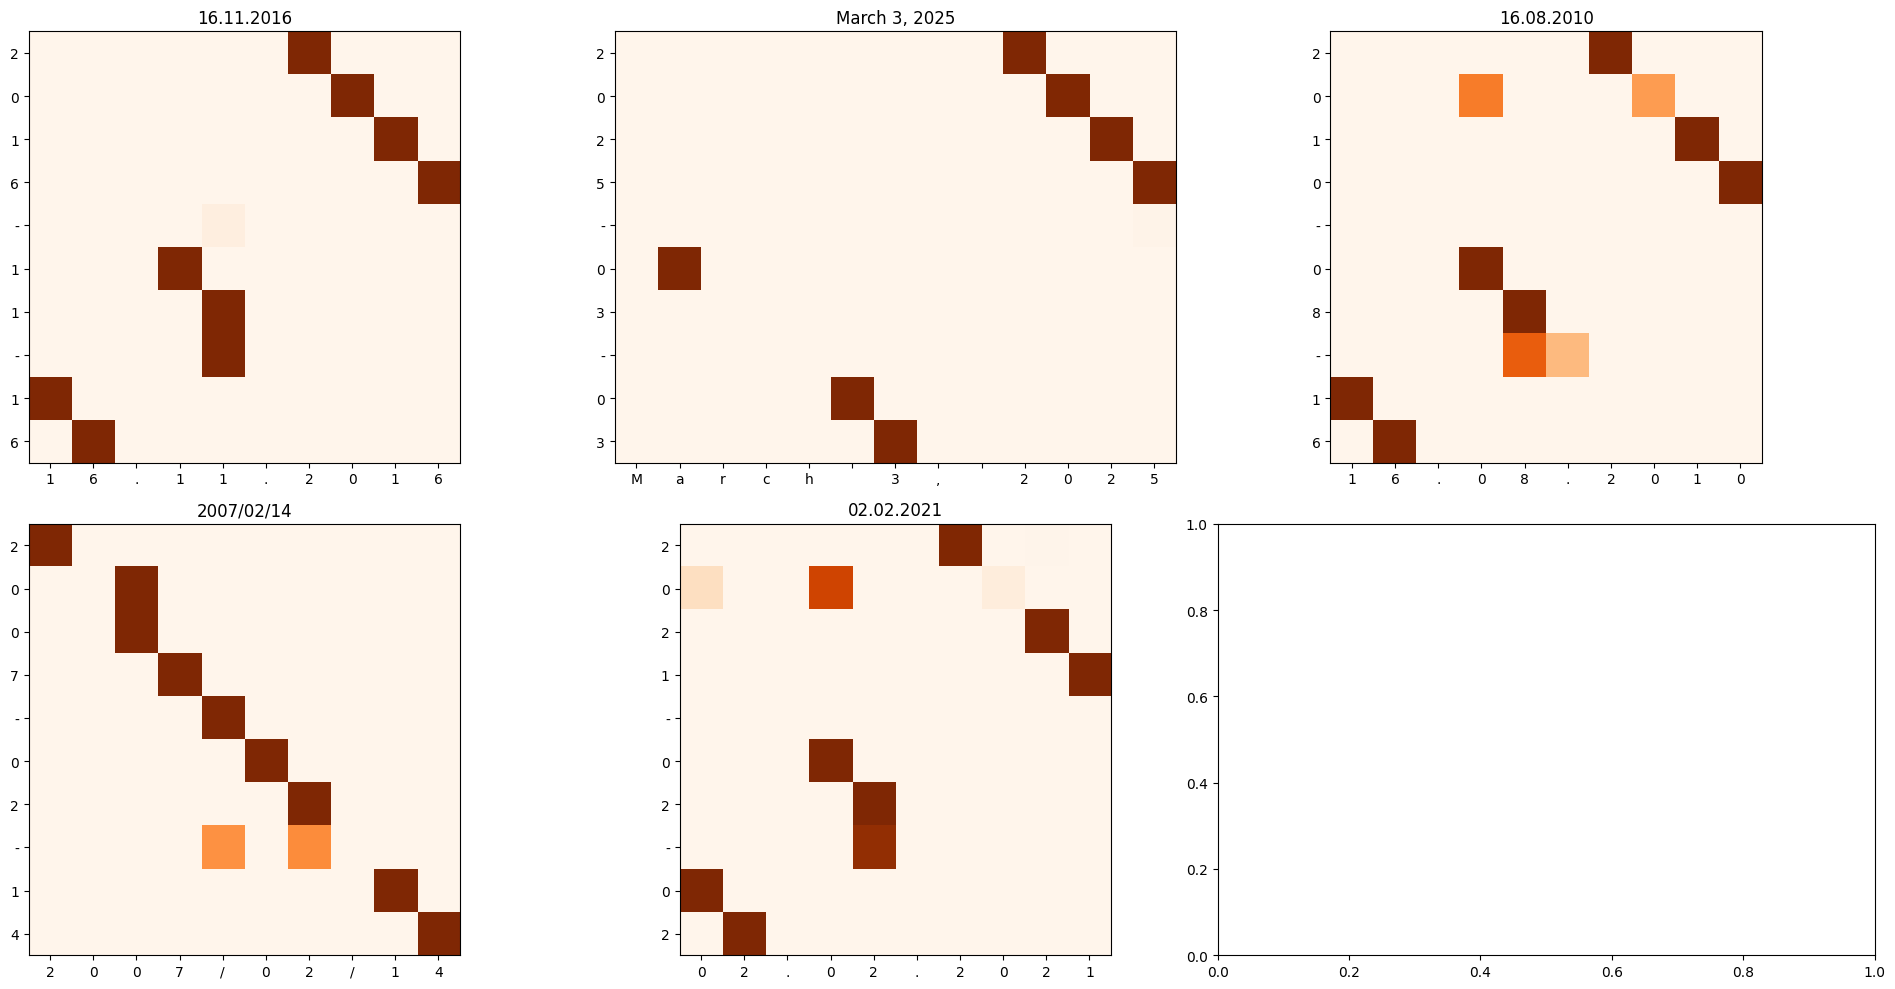

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for idx, (src, ref) in enumerate(test_date_pairs):
    pred, attn, src_chars = translate_date(src, date_luong_results['general']['encoder'], date_luong_results['general']['decoder'],
                                           date_src_vocab, date_tgt_vocab)
    ax = axes[idx // 3][idx % 3]
    if attn is not None and attn.shape[0] > 0:
        pred_chars = list(pred)
        src_labels = src_chars
        sl = min(attn.shape[1], len(src_labels))
        ol = min(attn.shape[0], len(pred_chars))
        ax.imshow(attn[:ol, :sl], cmap="Oranges", vmin=0, vmax=1)
        ax.set_xticks(range(sl))
        ax.set_xticklabels(src_labels[:sl])
        ax.set_yticks(range(ol))
        ax.set_yticklabels(pred_chars[:ol])

    ax.set_title(f"{src}")

plt.tight_layout()